# 신용카드 사기 거래 탐지 AI 경진대회

크게 3단계로 나눌수 있습니다.

1. feature engineering
    - feature correlation 분석 및 feature 선택
2. train dataset class mapping
    - validation data를 바탕으로 train dataset class 매핑
3. classifier problem
    - xgboost classifier 활용
    


## feature engineering

신용카드 거래 데이터는 이미 익명화 처리되었습니다.

도메인 지식으로는 feature와 fraud 간 관계를 찾는 방법은 시도할 수 없습니다.

그리하여, 통계적방법으로 feature-fraud 관계를 분석하여 feature를 선택했습니다.

새로운 feature를 생성하지 않았습니다. feature scaling을 제외한 feature 값 변형은 없습니다.

## train dataset class mapping

validation data의 fraud 정보를 train에 반영시키기위해 KNN(neighbor=1) classifier 이용했습니다.

feature engineering으로 정한 15개의 feature를 15차원의 벡터공간으로 생각하시면됩니다.

- KNN은 10차원 이상되면 Curse of Dimensionality(고차원의 저주)가 있다고합니다. 그래서 T-SNE, umap으로 차원을 축소하여 진행하였지만 성능이 떨어져서 15차원을 그대로 이용하였습니다. 15차원 이지만 가장 가까운 대상 하나의 정보만을 반영하기때문에 영향이 크지 않다고 생각됩니다.

## 분류 문제 해결

xgboost 이진 분류 모델을 이용했습니다.


- 분류 클래스 세분화
    - 사기 거래에도 종류가 있다는 가정에 class를 3개로 늘렸습니다. class를 나누는 기준은 t-sne, pca, svc 그래프를 통해 fraud/non-fraud 경계선 근처에 있는 fraud를 다른 클래스로 지정했습니다.
    - 즉, 3개의 클래스 : non-fraud, fraud-1(애매), fraud-2(확실)
    - 하지만, 클래스를 2개로 진행하는것이 더 나은 성능을 보여줬습니다. 이는 안그래도 부족한 fraud 데이터에서 소수의 애매한 fraud를 분리해서 클래스로 지정한것이 유의미한 분류모델을 만들기에 도움이 되지 않은것 같습니다.


- 클래스 불균형
    - SMOTE 패키지를 이용한 오버샘플링 방법과 xgboost의 파라미터로 scale_pos_weight를 주는 방법 중 scale_pos_weight를 주는 방법이 더 좋은 성능을 보여줬습니다.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import collections
from collections import Counter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit, StratifiedKFold, cross_val_score

import xgboost as xgb

import optuna

import umap

In [2]:
train_df = pd.read_csv('./data/train.csv').drop('ID', axis=1)
train_df#.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113837,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,5.498583,4.893089,8.655320,...,-0.944759,-1.565026,0.890675,-1.253276,1.786717,0.320763,2.090712,1.232864,-0.169496,1.034857
113838,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,0.120908,...,0.144008,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,0.530986,1.034881
113839,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,...,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,-0.230699,1.034904
113840,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,...,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,-0.269825,1.034939


In [3]:
valid_df = pd.read_csv('./data/val.csv').drop('ID', axis=1)
valid_df#.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28457,-0.546378,1.433992,-0.313252,0.926044,0.522388,-0.565669,1.066075,0.269799,-1.099446,-0.077753,...,0.778817,-0.175451,0.030397,0.018381,-0.395994,0.301655,0.173585,0.202753,1.034622,0
28458,-0.764523,0.588379,-0.907599,-0.418847,0.901528,-0.760802,0.758545,0.414698,-0.730854,-1.245088,...,-0.431876,0.141759,0.587119,-0.200998,0.267337,-0.152951,-0.065285,0.810452,1.034693,0
28459,-0.446951,1.302212,-0.168583,0.981577,0.578957,-0.605641,1.253430,-1.042610,-0.417116,0.076605,...,0.305268,-0.148093,-0.038712,0.010209,-0.362666,0.503092,0.229921,0.537972,1.034763,0
28460,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,...,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,-0.269964,1.034928,0


# scaling

- train data 스케일러 생성
MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler 실험한 결과 미묘한 차이지만 MaxAbsScaler에서만 가장 높은 결과가 나와서 선택했습니다.

참고 https://mkjjo.github.io/python/2019/01/10/scaler.html

In [4]:
v_columns = [f'V{i}' for i in range(1,31)]

In [5]:
scaler = MaxAbsScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
# sclaer = StandardScaler()
scaler.fit(train_df[v_columns])
train_df[v_columns] = scaler.transform(train_df[v_columns])
valid_df[v_columns] = scaler.transform(valid_df[v_columns])

# validation feature correlation 분석

- valid dataset의 feature와 fraud 간 correlation(pearson)을 검사했습니다.
- class 개수가 불균형하면 correlation 분석이 불가능하기 때문에, non-fraud 데이터 샘플링하여 fraud:non-fraud 비율을 1:1로 변경하여 correlation 분석했습니다.
- correlation value가 유의미한 15개의 feature를 선택했습니다.
- t-sne, pca, TruncatedSVD 방법으로 class 간 분포가 잘 될 것 같음도 확인도 되었습니다.

In [6]:
colors = ['#0101DF', '#DF0101']

In [7]:
print('No Frauds', round(valid_df['Class'].value_counts()[0]/len(valid_df) * 100,2), '% of the dataset')
print('Frauds', round(valid_df['Class'].value_counts()[1]/len(valid_df) * 100,2), '% of the dataset')

X = valid_df.drop('Class', axis=1)
y = valid_df['Class']

No Frauds 99.89 % of the dataset
Frauds 0.11 % of the dataset


In [8]:
valid_df = valid_df.sample(frac=1)

fraud_df = valid_df.loc[valid_df['Class'] == 1]
non_fraud_df = valid_df.loc[valid_df['Class'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_valid_df = normal_distributed_df.sample(frac=1, random_state=42)

new_valid_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
677,0.015199,0.056300,-0.228750,0.447526,0.023094,-0.104385,-0.033969,0.010659,-0.175017,-0.161628,...,0.016361,0.005370,-0.058329,-0.097605,0.139721,0.055526,0.004386,-0.001629,-0.868652,1
25042,-0.009083,0.066383,-0.245698,0.444725,0.008724,-0.078558,-0.066642,0.028090,-0.338298,-0.215468,...,-0.051704,-0.000209,-0.283488,-0.000626,0.169260,0.050188,0.003738,-0.001647,0.798715,1
19616,-0.013915,0.011850,0.039659,-0.042499,0.003273,0.007778,0.007331,-0.000770,0.044199,-0.016108,...,0.080233,-0.007789,-0.180493,-0.016660,0.121159,-0.037413,0.003658,-0.000932,0.532579,0
27,0.012884,-0.007262,0.001552,0.083294,-0.002945,0.015890,0.005892,0.001671,-0.000225,-0.002553,...,-0.011459,-0.006882,-0.067284,0.058707,-0.106976,-0.000354,0.001202,0.015748,-0.959305,0
1196,-0.290173,0.126846,-0.717030,0.718248,-0.224496,-0.093670,-0.384187,0.027172,-0.468044,-0.532828,...,0.113042,0.026518,-0.260308,-0.003455,0.213157,0.190629,-0.041856,-0.001629,-0.723784,1


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


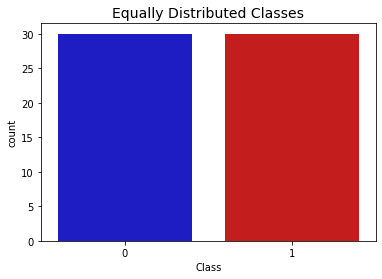

In [9]:
print('Distribution of the Classes in the subsample dataset')
print(new_valid_df['Class'].value_counts()/len(new_valid_df))

sns.countplot('Class', data=new_valid_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

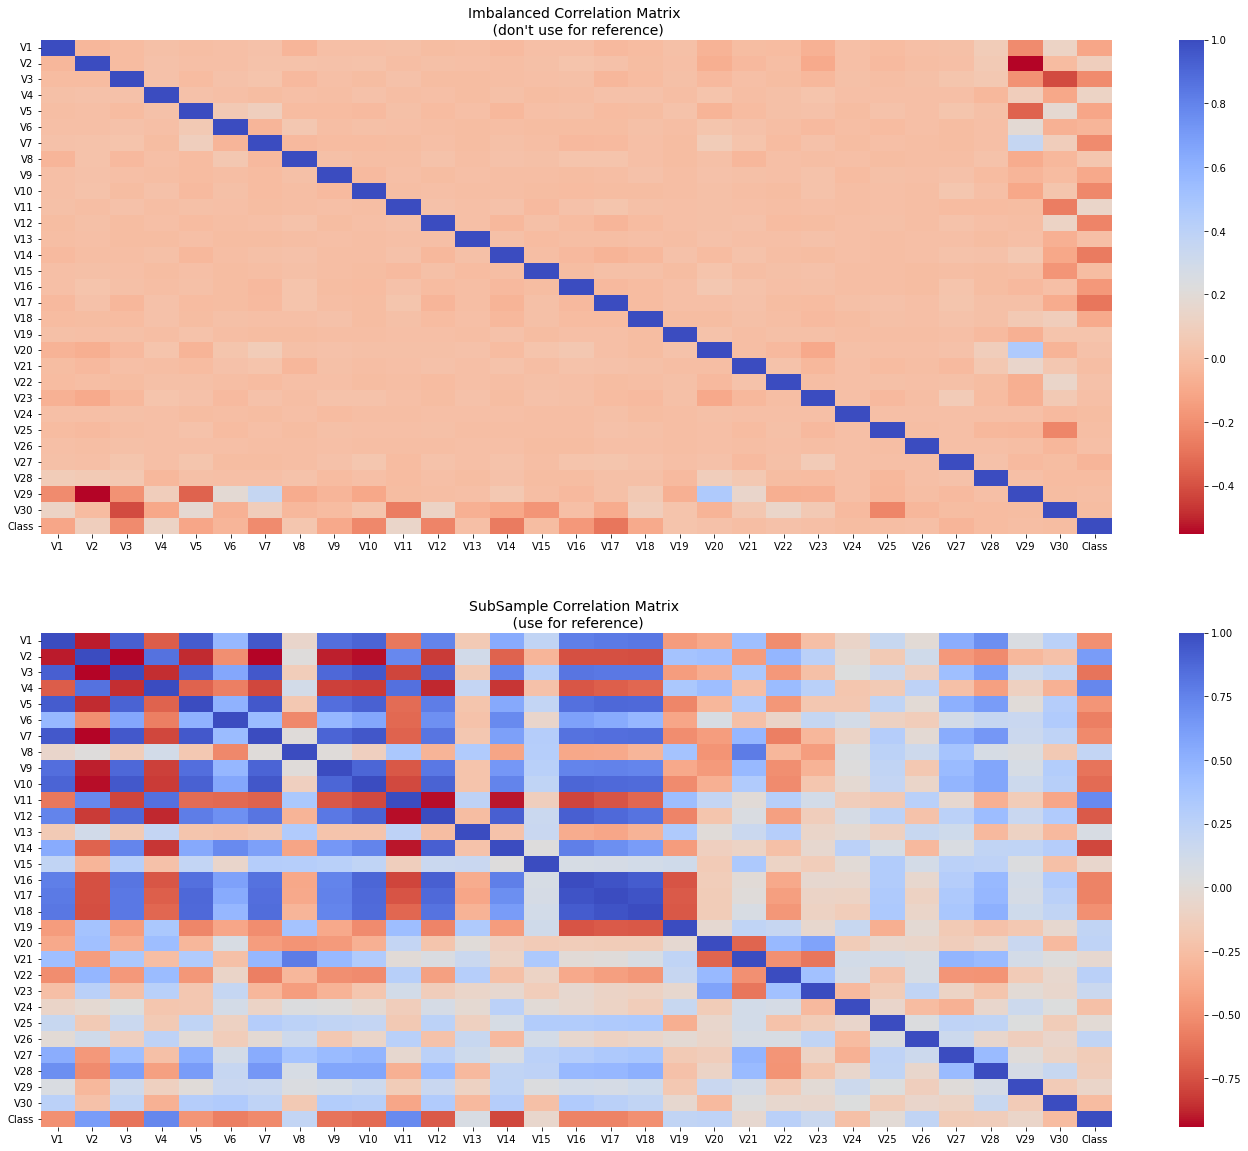

In [10]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = valid_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_valid_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [11]:
key_reverse = list(sub_sample_corr['Class'][:-1].sort_values().keys())

In [12]:
for idx, (k,v) in enumerate(sub_sample_corr['Class'][:-1].sort_values().items()):
    print(idx, k, v)

0 V14 -0.7843960875457404
1 V12 -0.7139580332083814
2 V10 -0.6577390131223071
3 V3 -0.6201229998114389
4 V9 -0.6169163821741401
5 V6 -0.5761268204471411
6 V16 -0.5595728865308565
7 V17 -0.5550211789390674
8 V7 -0.5293482730458026
9 V18 -0.4976618579131048
10 V1 -0.49512544482091975
11 V5 -0.47681975040710844
12 V30 -0.2677717506836077
13 V24 -0.23798442643991397
14 V27 -0.15558340295851214
15 V28 -0.13958050107505038
16 V29 -0.07514807214095914
17 V15 -0.05991321845673256
18 V21 -0.03999810562294697
19 V25 -0.0141878194090814
20 V13 0.06862597290485149
21 V23 0.1617783236726124
22 V8 0.20977144560741434
23 V19 0.21340676584054638
24 V26 0.2191353513126261
25 V20 0.22891258876469608
26 V22 0.26092325638799607
27 V2 0.6221318229928594
28 V11 0.7130697062759742
29 V4 0.7300204792659295


In [13]:
a = key_reverse[:12]
b = key_reverse[-3:]
use_columns = a + b
print(a)
print(b)
print(len(use_columns))

['V14', 'V12', 'V10', 'V3', 'V9', 'V6', 'V16', 'V17', 'V7', 'V18', 'V1', 'V5']
['V2', 'V11', 'V4']
15


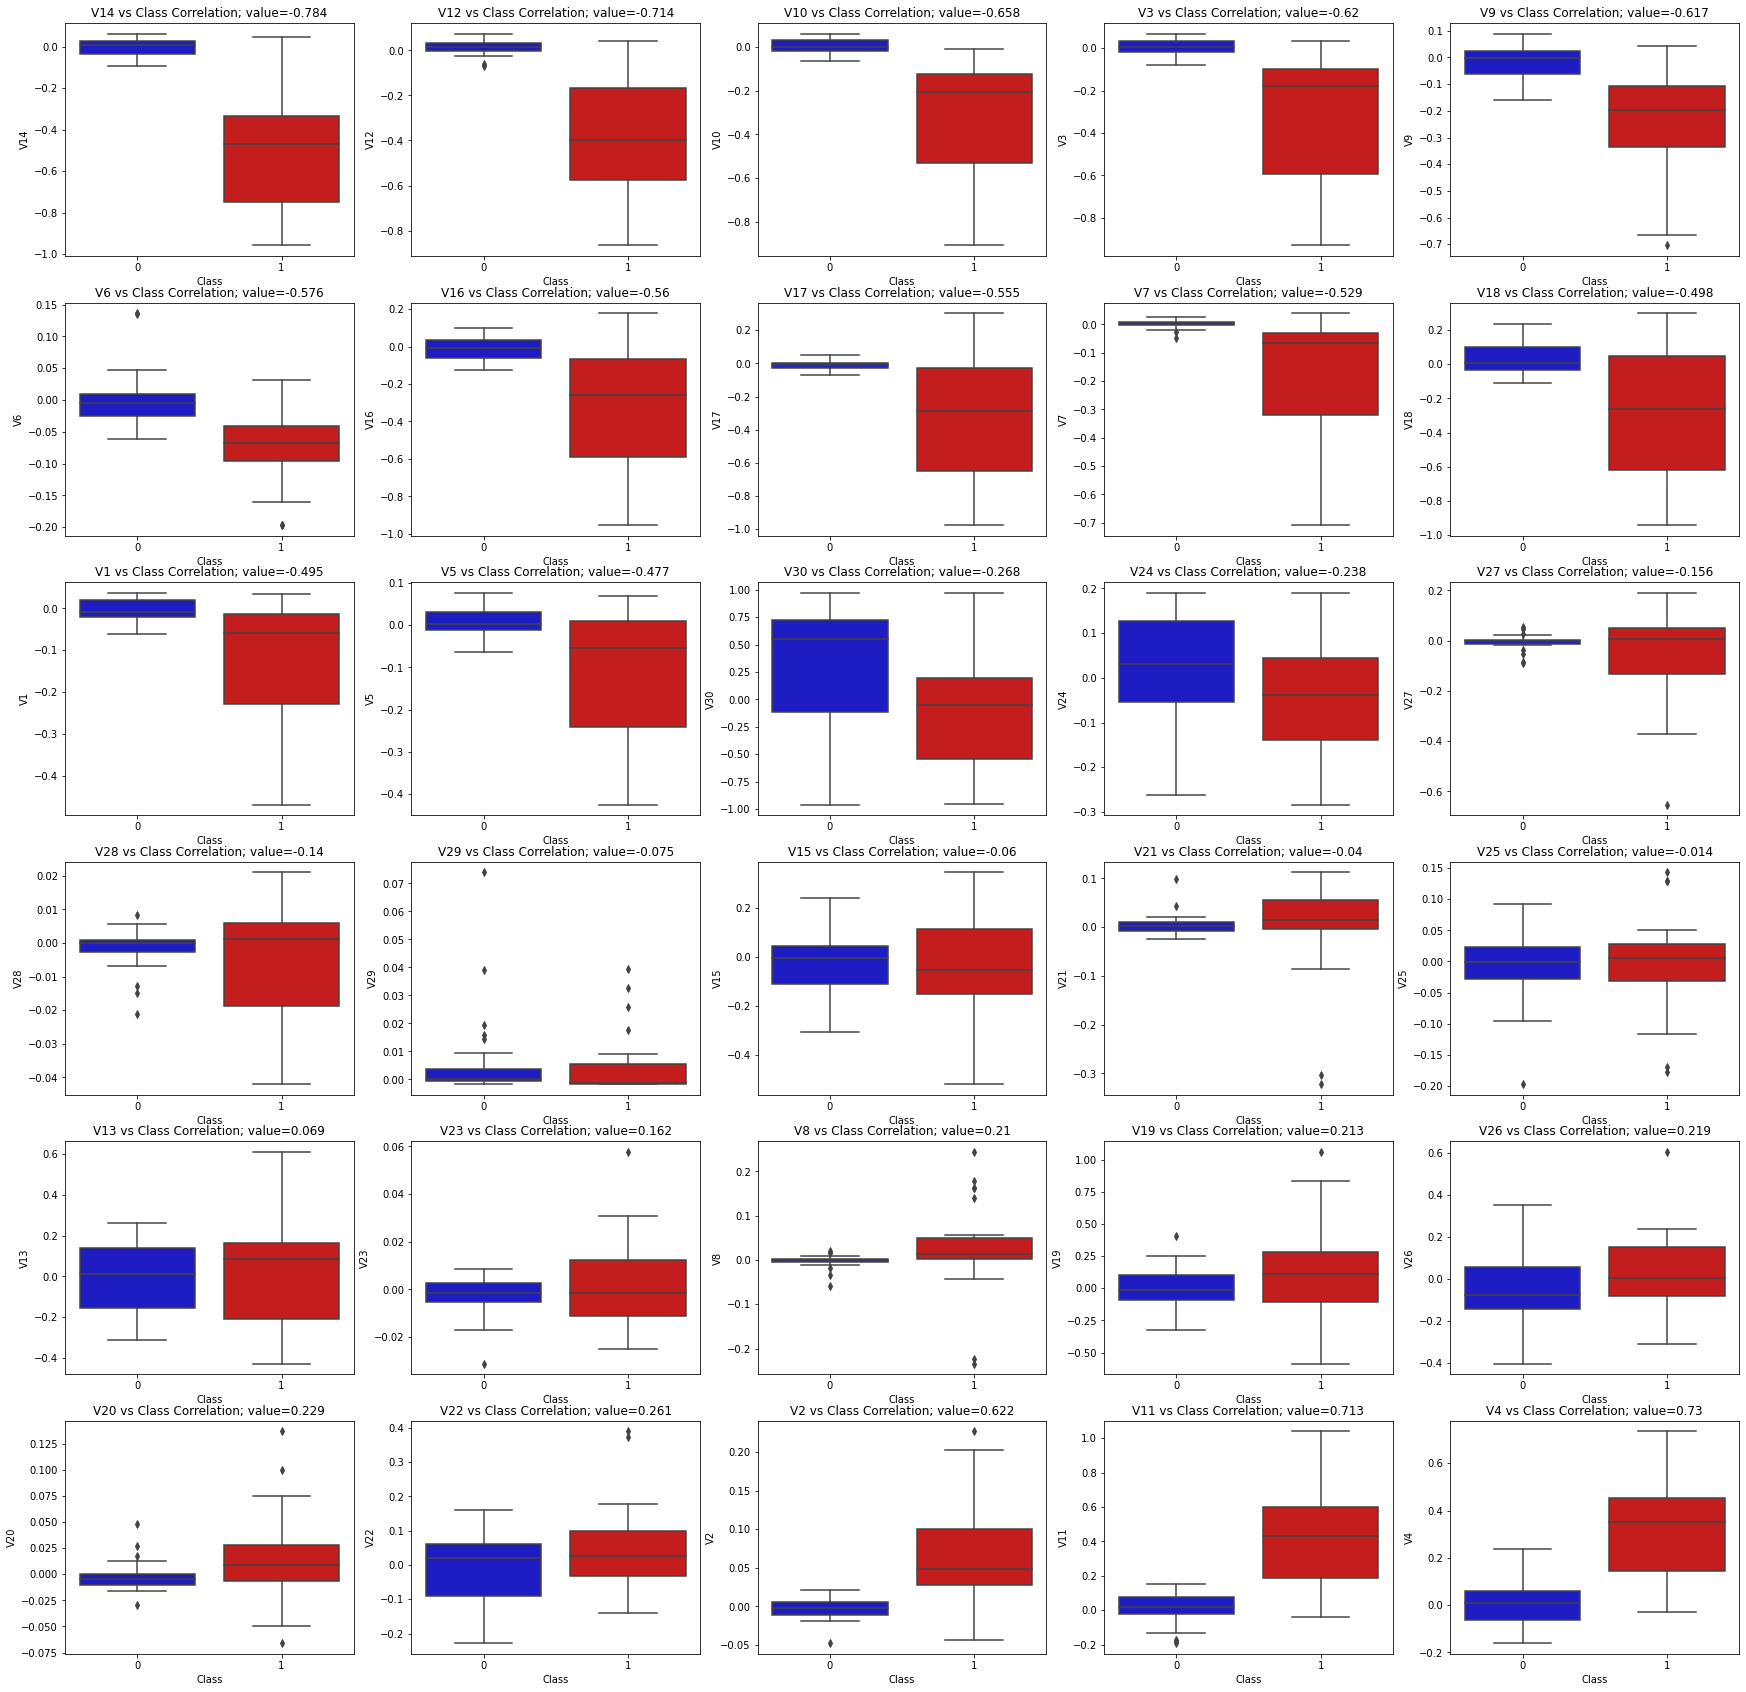

In [14]:
f, axes = plt.subplots(nrows=6, ncols=5, figsize=(30,30))

for idx, (k,v) in enumerate(sub_sample_corr['Class'][:-1].sort_values().items()):
    i, j = divmod(idx, 5)
    sns.boxplot(x="Class", y=k, data=new_valid_df, palette=colors, ax=axes[i, j])
    axes[i,j].set_title(f'{k} vs Class Correlation; value={round(v,3)}')

In [16]:
for idx, (k,v) in enumerate(sub_sample_corr['Class'][:-1].sort_values()[:5].items()):
    v_fraud = new_valid_df[k].loc[new_valid_df['Class']==1].values
    q25, q75 = np.percentile(v_fraud, 25), np.percentile(v_fraud, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    v_iqr = q75 - q25
    print(f'iqr: {v_iqr}')
    
    v_cut_off = v_iqr * 1.5
    v_lower, v_upper = q25 - v_cut_off, q75 + v_cut_off
    print(f'Cut off: {v_cut_off}')
    print(f'{k} Lower: {v_lower}')
    print(f'{k} upper: {v_upper}')
    
    outliers = [x for x in v_fraud if x < v_lower or x > v_upper]
    print(f'Feature {k} Outliers for Fraud Cases: {len(outliers)}'.format())
    print(f'{k} outliers:{outliers}')

    new_valid_df = new_valid_df.drop(new_valid_df[(new_valid_df[k] > v_upper) | (new_valid_df[k] < v_lower)].index)
    print('Number of Instances after outliers removal: {}'.format(len(new_valid_df)))
    print('----' * 44)

Quartile 25: -0.746733224874017 | Quartile 75: -0.33479639988945925
iqr: 0.4119368249845578
Cut off: 0.6179052374768367
V14 Lower: -1.3646384623508538
V14 upper: 0.2831088375873774
Feature V14 Outliers for Fraud Cases: 0
V14 outliers:[]
Number of Instances after outliers removal: 60
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Quartile 25: -0.5772580118123027 | Quartile 75: -0.1689270624257557
iqr: 0.408330949386547
Cut off: 0.6124964240798205
V12 Lower: -1.1897544358921233
V12 upper: 0.4435693616540648
Feature V12 Outliers for Fraud Cases: 0
V12 outliers:[]
Number of Instances after outliers removal: 60
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Quartile 25: -0.5319465889009106 | Quartile 75: -0.12153552210113205
iqr: 0.410

In [17]:
# New_df is from the random undersample data (fewer instances)
X = new_valid_df.drop('Class', axis=1)[use_columns]
y = new_valid_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42, learning_rate='auto', init='pca').fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


T-SNE took 0.43 s
PCA took 0.00067 s
Truncated SVD took 0.0019 s


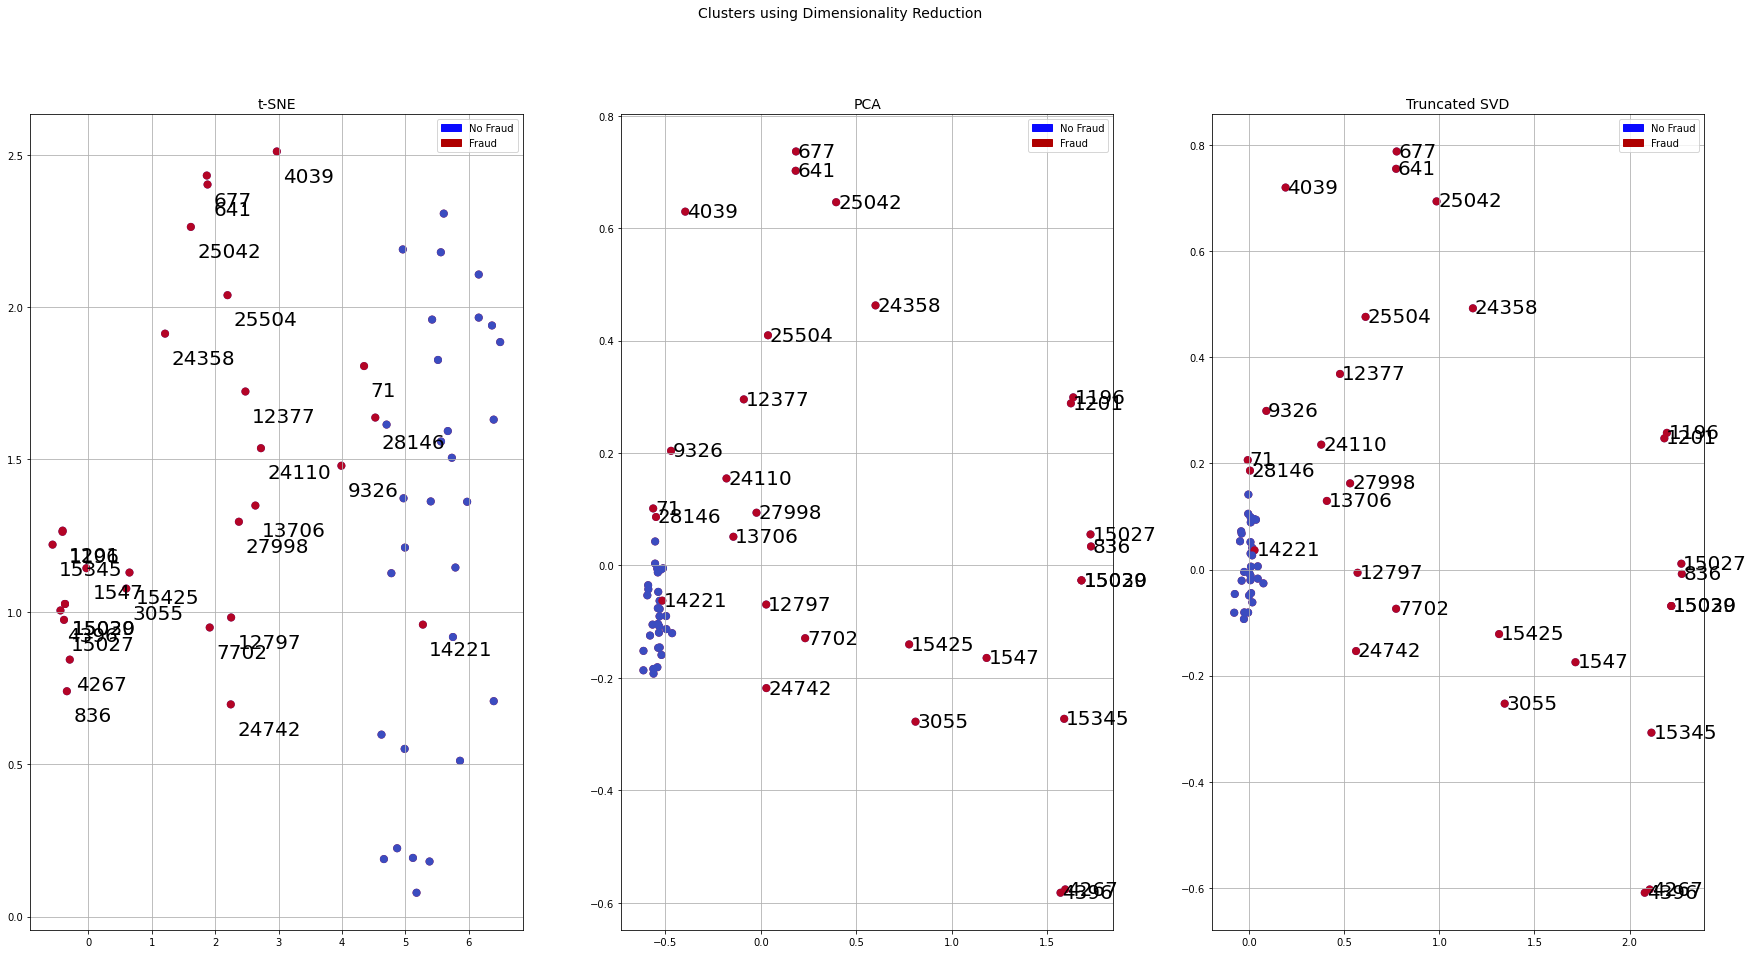

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,15))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
for i in range(len(y)):
    if y.iloc[i]==1:
        # ax1.text(X_reduced_tsne[i,0], X_reduced_tsne[i,1], s=y.keys()[i], fontsize=15)
        ax1.annotate(y.keys()[i], (X_reduced_tsne[i,0]+0.1, X_reduced_tsne[i,1]-0.1), fontsize=20)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
for i in range(len(y)):
    if y.iloc[i]==1:
        # ax1.text(X_reduced_tsne[i,0], X_reduced_tsne[i,1], s=y.keys()[i], fontsize=15)
        ax2.annotate(y.keys()[i], (X_reduced_pca[i,0]+0.01, X_reduced_pca[i,1]-0.01), fontsize=20)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
for i in range(len(y)):
    if y.iloc[i]==1:
        # ax1.text(X_reduced_tsne[i,0], X_reduced_tsne[i,1], s=y.keys()[i], fontsize=15)
        ax3.annotate(y.keys()[i], (X_reduced_svd[i,0]+0.01, X_reduced_svd[i,1]-0.01), fontsize=20)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# KNN labeling (Valid -> Train)

- 분류모델을 학습하기위해서 train dataset에 class를 지정하는 작업을합니다.
- training data를 기준으로 MaxAbsScaling을 진행하고, 15개의 feature만 선택한 train/valid dataset을 생성합니다.
- train data 하나의 거래와 valid data 모든 거래에 대해서, 15개의 feature에 대해 유클리드 거리를 계산하여 가장 가까운 거래를 찾습니다. 그리고 하나의 train 거래를 valid 거래의 class로 라벨링합니다.
    - 즉, neighbor=1 KNN classifer를 이용해서 train data의 class를 정해주겠다는 말입니다.
    - 그리하여 train의 fraud 비율이 0.106%가 나왔습니다. valid의 비율인 0.11%와 비슷하므로 valid의 정보를 잘 반영한다고 판단할 수 있을것 같습니다.
- knn classifer로 predict 할 때, probability threshold를 조절하는 실험을 진행했습니다. fraud 자체는 데이터가 매우 없기 때문에 적은 확률이라도 fraud 확률이 있다면 fraud라고 판단하는게 추후 모델학습 시 강건한 모델이 될 수 있다고 판단했습니다.
    - 실험 결과로는 0.5에서 가장 높았습니다.

In [20]:
print(f'v cnt: {len(use_columns)} ::::', end=' ')
for c in use_columns:
    print(c, sep='', end=' ')

v cnt: 15 :::: V14 V12 V10 V3 V9 V6 V16 V17 V7 V18 V1 V5 V2 V11 V4 

In [21]:
train_df = pd.read_csv('./data/train.csv').drop('ID', axis=1)
valid_df = pd.read_csv('./data/val.csv').drop('ID', axis=1)

In [22]:
train_df = train_df[use_columns]
valid_df = valid_df[use_columns+['Class']]

In [23]:
scaler = MaxAbsScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()
scaler.fit(train_df[use_columns])
train_df[use_columns] = scaler.transform(train_df[use_columns])
valid_df[use_columns] = scaler.transform(valid_df[use_columns])

In [24]:
fraud_ratio = valid_df['Class'].value_counts()[1]/len(valid_df)
fraud_ratio

0.0010540369615627855

In [25]:
X = valid_df.drop('Class', axis=1).values
y = valid_df['Class'].values

In [29]:
neigh = KNeighborsClassifier(n_neighbors=1, weights='distance', algorithm='brute', n_jobs=-1)
neigh.fit(X, y)

KNeighborsClassifier(algorithm='brute', n_jobs=-1, n_neighbors=1,
                     weights='distance')

In [30]:
probs = neigh.predict_proba(train_df.values)

In [31]:
neigh.predict(train_df.values).sum()

121

In [32]:
cnt = 0
train_class = np.zeros(len(train_df), dtype=int)
for idx in np.flip(np.argsort(probs[:,1])):
    cnt += 1
    if probs[idx,1] < 0.5:
        break
    # if probs[idx,1] <= 0:
    #     break
    train_class[idx] = 1
train_df['Class'] = train_class

In [ ]:
print(train_df['Class'].value_counts())

# xgboost 학습 파라미터
scale_pos_weight = train_df['Class'].value_counts()[0] / train_df['Class'].value_counts()[1]
print(scale_pos_weight)

# train

- 이제 train data는 fraud/non-fraud 로 binary labelling 되었습니다.
- 분류모델로는 xgboost를 이용했습니다.
- optuna를 이용해서 최적의 hyper parameter를 탐색했습니다.

In [34]:
X = train_df.drop('Class', axis=1)
y = train_df['Class']

In [36]:
def RF_objective(trial: optuna.trial.Trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric':'auc',
        'booster':'gbtree',
        'n_estimators': trial.suggest_int("n_estimators", 100, 1000, step=10),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        
        'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
        # "tree_method": 'exact', 'gpu_id': -1,  # CPU 사용시
        
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
        'scale_pos_weight': scale_pos_weight
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 5, 20, step=5)
        
        # "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
        # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500) 추가하면 느려짐.
    }

    model = xgb.XGBClassifier(**params, random_state = 42, use_label_encoder = False, n_jobs=-1)
    
    cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1)
    f1_mean = score.mean()

    return f1_mean

In [37]:
# optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
#Execute optuna and set hyperparameters
RF_study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
RF_study.optimize(RF_objective, n_trials=1000)

In [47]:
RF_study.best_params

{'n_estimators': 460,
 'max_depth': 4,
 'gamma': 0.7155935590497422,
 'min_child_weight': 1,
 'subsample': 0.95,
 'colsample_bytree': 0.8516143607917493,
 'colsample_bylevel': 0.8499089569307289,
 'colsample_bynode': 0.7783533814866374,
 'reg_lambda': 0.20646353054278152,
 'reg_alpha': 0.031101827218005206}

In [48]:
#Create an instance with tuned hyperparameters
rfc = xgb.XGBClassifier(**RF_study.best_params, objective='binary:logistic', eval_metric='auc', booster='gbtree', scale_pos_weight=scale_pos_weight, random_state = 42, use_label_encoder = False, n_jobs=-1)

In [49]:
rfc.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8499089569307289,
              colsample_bynode=0.7783533814866374,
              colsample_bytree=0.8516143607917493, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc',
              gamma=0.7155935590497422, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=460,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.031101827218005206, reg_lambda=0.20646353054278152, ...)

In [50]:
y_pred = rfc.predict(X)

In [51]:
# rfc.predict_proba(X_test)

In [52]:
print(classification_report(y, y_pred, target_names=['No Frauds', 'Frauds']))

              precision    recall  f1-score   support

   No Frauds       1.00      1.00      1.00    113721
      Frauds       1.00      1.00      1.00       121

    accuracy                           1.00    113842
   macro avg       1.00      1.00      1.00    113842
weighted avg       1.00      1.00      1.00    113842



In [55]:
classification_report(y, y_pred, target_names=['No Frauds', 'Frauds'], output_dict=True)

{'No Frauds': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 113721},
 'Frauds': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 121},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 113842},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 113842}}

In [54]:
f1score = classification_report(y, y_pred, target_names=['No Frauds', 'Frauds'], output_dict=True)['macro avg']['f1-score']
f1score

1.0

# inference - submission

In [56]:
test_df = pd.read_csv('./data/test.csv')
ids = test_df['ID']
test_df = test_df[use_columns]

In [57]:
test_df

,V14,V12,V10,V3,V9,V6,V16,V17,V7,V18,V1,V5,V2,V11,V4
0,-0.311169,-0.617801,0.090794,2.536347,0.363787,0.462388,-0.470401,0.207971,0.239599,0.025791,-1.359807,-0.338321,-0.072781,-0.551600,1.378155
1,-0.143772,1.065235,-0.166974,0.166480,-0.255425,-0.082361,0.463917,-0.114805,-0.078803,-0.183361,1.191857,0.060018,0.266151,1.612727,0.448154
2,-1.119670,0.538196,0.753074,1.548718,0.817739,0.095921,-0.451449,-0.237033,0.592941,-0.038195,-1.158233,-0.407193,0.877737,-0.822843,0.403034
3,0.167372,-0.153826,-0.099254,0.045371,0.464960,0.272708,-0.443587,0.002821,-0.005159,-0.611987,1.229658,0.191881,0.141004,-1.416907,1.202613
4,0.362832,-0.326143,0.309755,-0.874300,-0.558895,3.317027,-0.129487,-0.809979,0.470455,0.359985,0.384978,2.924584,0.616109,-0.259116,-0.094019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142498,1.122674,-0.453235,-0.111640,-0.635891,-0.285670,-1.014307,-1.431897,0.939328,0.427126,-0.002373,0.219529,-0.152971,0.881246,-1.109232,0.960928
142499,-0.858719,0.453596,-0.594242,1.189786,1.159498,5.519980,-0.644646,0.447184,-1.518185,0.388721,-1.775135,1.196063,-0.004235,-1.264072,0.331096
142500,-0.675143,0.915802,-0.975926,2.035030,0.584800,1.058415,-0.711757,-0.025693,0.024330,-1.221179,-0.732789,0.868229,-0.055080,-0.150189,-0.738589
142501,-0.510602,0.063119,-0.484782,-3.249640,0.432454,3.031260,0.140716,0.313502,-0.296827,0.395652,1.919565,2.630515,-0.301254,0.411614,-0.557828


In [58]:
test_df[use_columns] = scaler.transform(test_df[use_columns])

In [59]:
y_pred = rfc.predict(test_df)

In [60]:
print(len(y_pred[y_pred==0]))
print(len(y_pred[y_pred==1]))
print(len(y_pred[y_pred==1])/len(y_pred))
inference_fraud_ratio = len(y_pred[y_pred==1])/len(y_pred) * 100
print(inference_fraud_ratio)

142199
304
0.002133288421998133
0.21332884219981332


In [61]:
test_df['Class'] = y_pred
test_df['ID'] = ids

In [62]:
path = f'./xgboost-{round(inference_fraud_ratio,5)}-{round(f1score, 4)}.csv'
print(path)

./xgboost-0.21333-1.0.csv


In [63]:
test_df.to_csv(path, columns=['ID','Class'], index=False)